In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/fl_ev_registrations_public.csv')

In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2018-06-30,29433.0
2018-12-31,37776.0
2019-12-31,56980.0
2020-06-30,63750.0
2020-12-31,72814.0
2021-07-19,93221.0


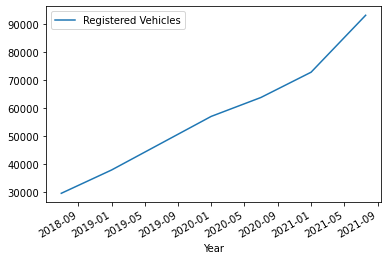

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

## **RESAMPLING

In [5]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [6]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

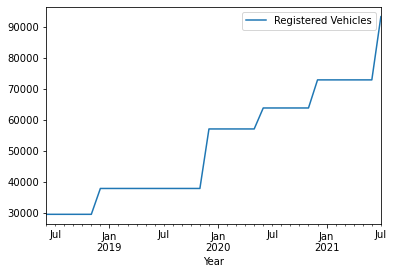

In [7]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [8]:
adtest = adfuller(df)
display(adtest)

(0.428734211177527,
 0.9825382724587107,
 0,
 37,
 {'1%': -3.6209175221605827,
  '5%': -2.9435394610388332,
  '10%': -2.6104002410518627},
 545.1143913732272)

## Modeling

In [9]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2018-06-30':'2020-12-31']
test = df['2020-12-31':]
combined = df

test

,Registered Vehicles
Year,
2020-12-31,72814.0
2021-01-31,72814.0
2021-02-28,72814.0
2021-03-31,72814.0
2021-04-30,72814.0
2021-05-31,72814.0
2021-06-30,72814.0
2021-07-31,93221.0


In [10]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=758.298, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=742.286, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=618.380, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=620.387, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=742.303, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=618.167, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=658.336, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=616.032, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=682.388, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=618.219, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=620.049, Time=0.08 se

### The best model is :  ARIMA (1,00) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0292      0.017     59.005      0.000       0.995       1.063
sigma2      1.699e+07   1.43e-10   1.19e+17      0.000     1.7e+07     1.7e+07


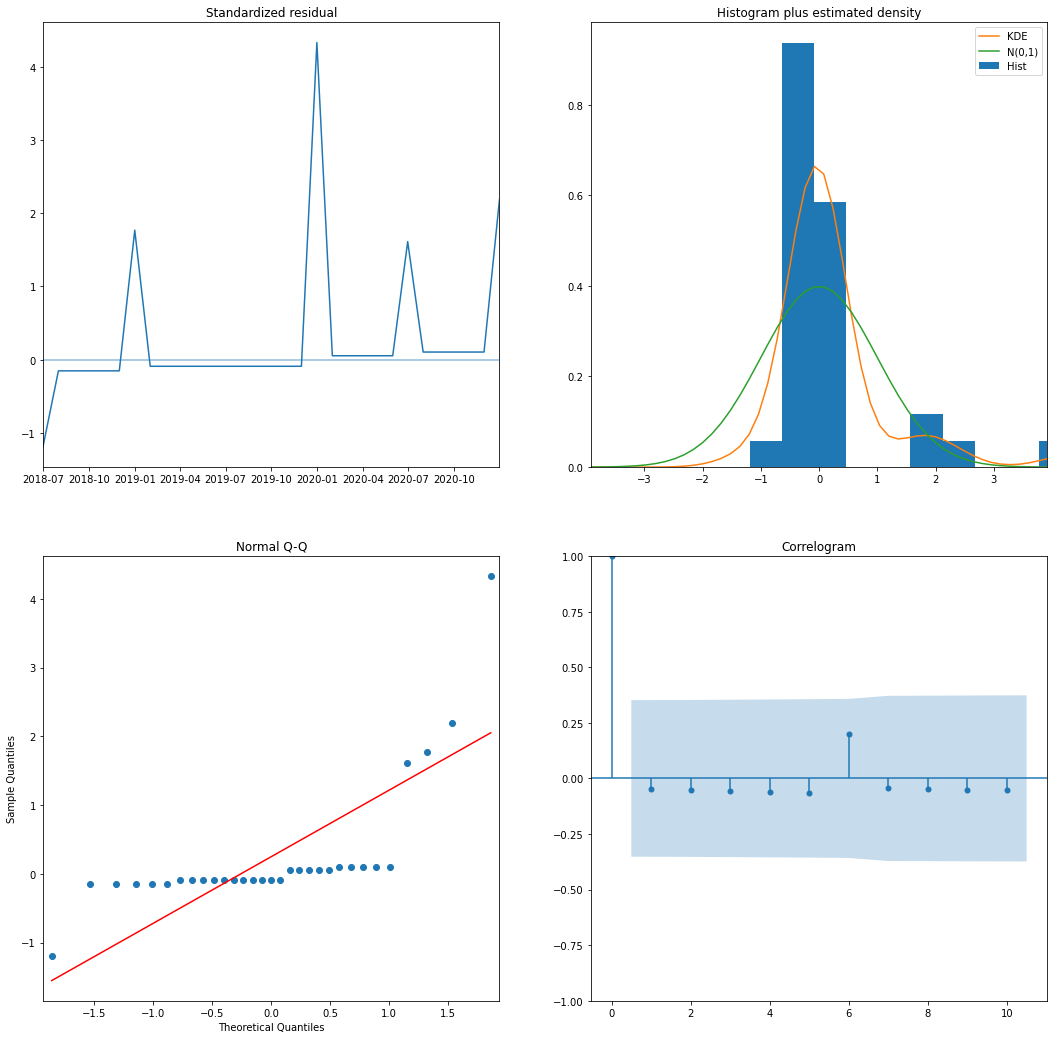

In [11]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(1,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [12]:
pred = output.get_prediction(start=pd.to_datetime('2020-12-31'), end=pd.to_datetime('2021-07-19'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2020-12-31,57533.485653,73693.249767
2021-01-31,66862.420004,83022.184119
2021-02-28,65537.934552,88727.691242
2021-03-31,64975.556980,93799.144671
2021-04-30,64816.855333,98598.719294
2021-05-31,64925.491067,103266.605992
2021-06-30,65232.933000,107875.300886
2021-07-31,65699.409339,112468.656599


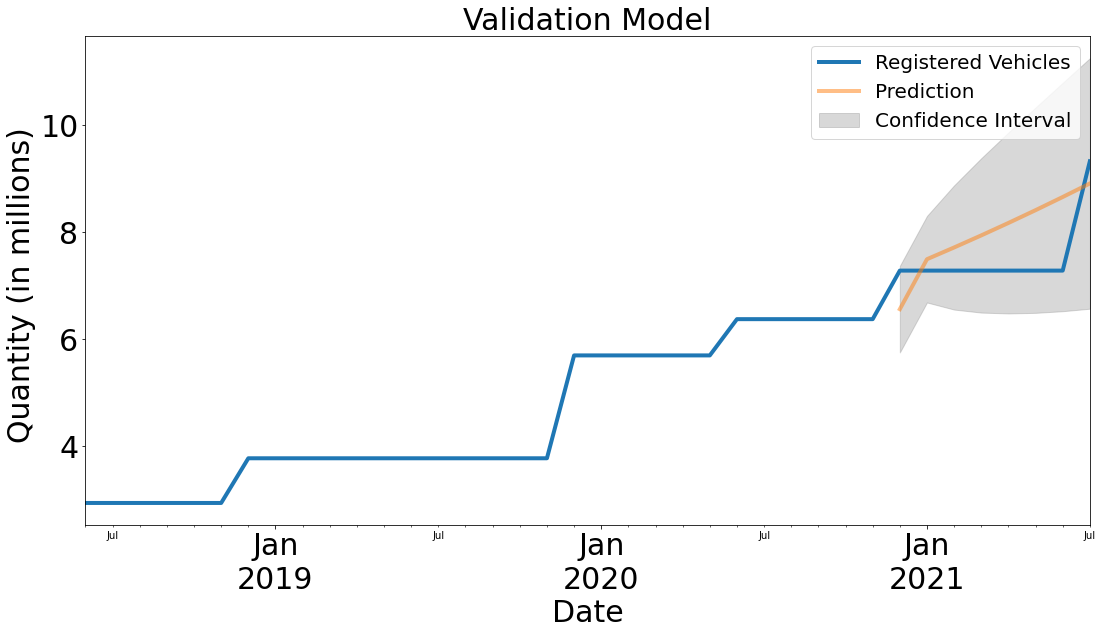

In [13]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in millions) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e4
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()